In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
import joblib
from datetime import datetime

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

print("All libraries imported.")

All libraries imported.


In [53]:
# Load the feature‑engineered dataset (with lags and rolling stats)
data_path = "../data/feature_engineered/vegetable_prices_fe.csv"
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (4944, 44)


,vegetable,price,Badulla_actual_class,Hambantota_actual_class,Jaffna_actual_class,Kurunegala_actual_class,Matale_actual_class,Nuwara_Eliya_actual_class,Ratnapura_actual_class,Badulla_precipitation,...,Matale_prob_normal,Nuwara_Eliya_prob_normal,Ratnapura_prob_normal,USD_LKR_avg,RateChange_avg_%,week_num,price_lag1,price_lag2,price_roll_mean_4,price_roll_std_4
0,1,75.6,-1,-1,-1,-1,-1,-1,-1,5.428571,...,0.012857,0.004286,0.008571,113.83,-0.06,1,67.5,52.4,65.166667,11.774690
1,1,60.0,1,1,1,1,1,-1,-1,21.025714,...,0.758571,0.014286,0.015714,126.25,-0.90,1,75.6,67.5,63.875000,9.955024
2,1,66.0,-1,-1,-1,0,0,0,0,2.248571,...,0.992857,0.974286,0.998571,130.70,0.00,1,60.0,75.6,67.275000,6.426702
3,1,132.0,-1,-1,-1,-1,-1,-1,-1,0.792857,...,0.025714,0.021429,0.015714,131.50,0.15,1,66.0,60.0,83.400000,33.030895
4,1,134.0,-1,-1,-1,-1,-1,-1,-1,6.584286,...,0.017143,0.004286,0.007143,143.72,-0.13,1,132.0,66.0,98.000000,40.496913


In [54]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First split: separate train + temp (val + test)
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42)

# Second split: split temp into val and test
val_df, test_df = train_test_split(temp_df, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)

print(f"Train set size: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df):.1%})")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df):.1%})")

# Verify disjoint sets
assert set(train_df.index).isdisjoint(set(val_df.index))
assert set(train_df.index).isdisjoint(set(test_df.index))
assert set(val_df.index).isdisjoint(set(test_df.index))
print("All checks passed – splits are correct.")

Train set size: 3460 (70.0%)
Validation set size: 742 (15.0%)
Test set size: 742 (15.0%)
All checks passed – splits are correct.


In [55]:
target_col = 'price'
feature_cols = [col for col in train_df.columns if col != target_col]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Number of features: {len(feature_cols)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Number of features: 43
Training samples: 3460
Validation samples: 742
Test samples: 742


In [56]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Calculate metrics on train, validation, and test sets."""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    metrics = {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Validation MAE': val_mae,
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'Validation R2': val_r2,
        'Test R2': test_r2
    }

    print(f"\n{'='*50}")
    print(f"{model_name} Performance:")
    print(f"{'='*50}")
    print(f"  Train RMSE: {train_rmse:.4f} | Validation RMSE: {val_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE : {train_mae:.4f} | Validation MAE : {val_mae:.4f} | Test MAE : {test_mae:.4f}")
    print(f"  Train R2  : {train_r2:.4f} | Validation R2  : {val_r2:.4f} | Test R2  : {test_r2:.4f}")

    return metrics, y_train_pred, y_val_pred, y_test_pred

In [57]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    gamma=0.1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

xgb_metrics, xgb_train_pred, xgb_val_pred, xgb_test_pred = evaluate_model(
    xgb_model, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost (Regularized)"
)

models = {'XGBoost (Regularized)': xgb_model}


XGBoost (Regularized) Performance:
  Train RMSE: 31.4053 | Validation RMSE: 40.2317 | Test RMSE: 33.9078
  Train MAE : 22.9087 | Validation MAE : 27.8652 | Test MAE : 24.6931
  Train R2  : 0.9182 | Validation R2  : 0.8132 | Test R2  : 0.8609


In [58]:
lgb_model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=20,
    min_split_gain=0.1,
    verbosity=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse'
)

lgb_metrics, lgb_train_pred, lgb_val_pred, lgb_test_pred = evaluate_model(
    lgb_model, X_train, y_train, X_val, y_val, X_test, y_test, "LightGBM (Regularized)"
)

models['LightGBM (Regularized)'] = lgb_model


LightGBM (Regularized) Performance:
  Train RMSE: 33.5005 | Validation RMSE: 39.8726 | Test RMSE: 32.4406
  Train MAE : 20.8875 | Validation MAE : 26.3308 | Test MAE : 22.9183
  Train R2  : 0.9069 | Validation R2  : 0.8165 | Test R2  : 0.8727


In [59]:
cb_model = cb.CatBoostRegressor(
    random_seed=42,
    iterations=100,
    learning_rate=0.05,
    depth=4,
    l2_leaf_reg=3.0,
    bagging_temperature=0.5,
    border_count=128,
    verbose=False
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

cb_metrics, cb_train_pred, cb_val_pred, cb_test_pred = evaluate_model(
    cb_model, X_train, y_train, X_val, y_val, X_test, y_test, "CatBoost (Regularized)"
)

models['CatBoost (Regularized)'] = cb_model


CatBoost (Regularized) Performance:
  Train RMSE: 44.1675 | Validation RMSE: 48.6086 | Test RMSE: 39.2436
  Train MAE : 30.5576 | Validation MAE : 33.8540 | Test MAE : 28.9997
  Train R2  : 0.8382 | Validation R2  : 0.7273 | Test R2  : 0.8137


In [60]:
# Combine metrics
metrics_list = [xgb_metrics, lgb_metrics, cb_metrics]
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

print("\n" + "="*60)
print("MODEL COMPARISON (TEST SET)")
print("="*60)
print(metrics_df[['Test RMSE', 'Test MAE', 'Test R2']].round(4))

# Identify best model by test RMSE
best_model = metrics_df['Test RMSE'].idxmin()
print(f"\n🏆 Best model by Test RMSE: {best_model} (RMSE: {metrics_df.loc[best_model, 'Test RMSE']:.4f})")


MODEL COMPARISON (TEST SET)
                        Test RMSE  Test MAE  Test R2
Model                                               
XGBoost (Regularized)     33.9078   24.6931   0.8609
LightGBM (Regularized)    32.4406   22.9183   0.8727
CatBoost (Regularized)    39.2436   28.9997   0.8137

🏆 Best model by Test RMSE: LightGBM (Regularized) (RMSE: 32.4406)


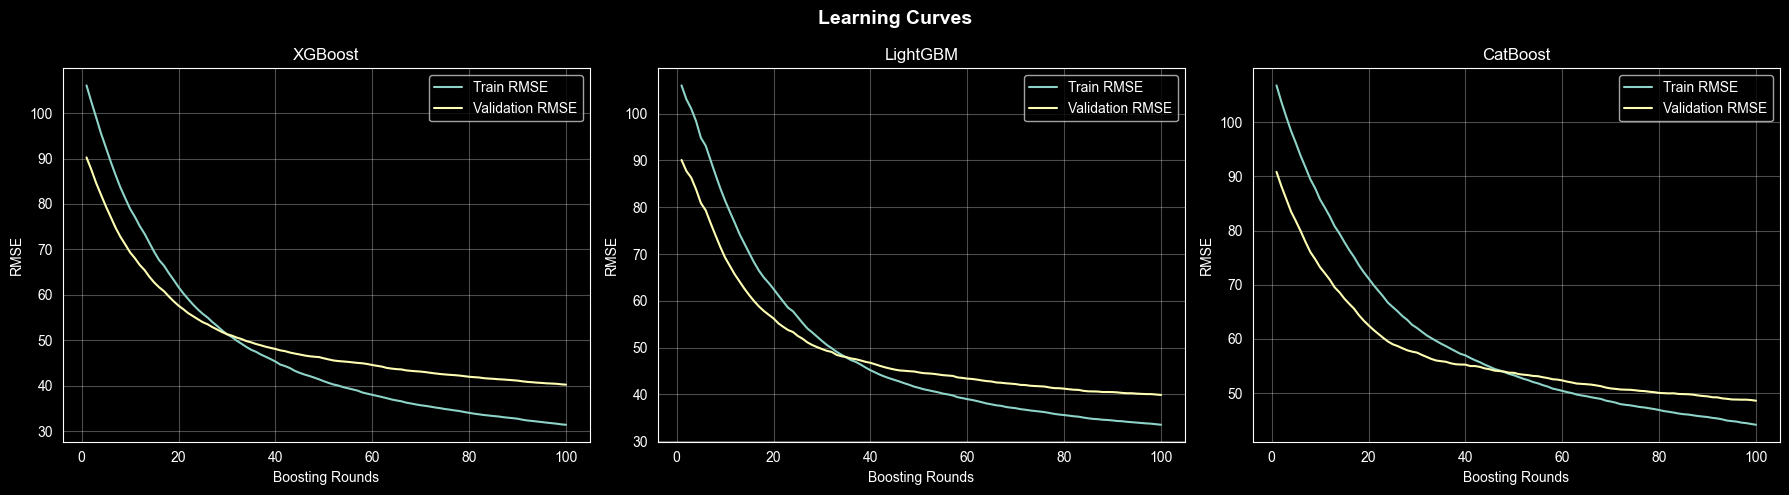

In [61]:
# XGBoost
xgb_results = xgb_model.evals_result()
xgb_train_rmse = xgb_results['validation_0']['rmse']
xgb_val_rmse = xgb_results['validation_1']['rmse']

# LightGBM
lgb_results = lgb_model.evals_result_
lgb_train_key = 'training'
lgb_val_key = [k for k in lgb_results.keys() if k != lgb_train_key][0]
lgb_train_rmse = lgb_results[lgb_train_key]['rmse']
lgb_val_rmse = lgb_results[lgb_val_key]['rmse']

# CatBoost
cb_results = cb_model.get_evals_result()
cb_train_rmse = cb_results['learn']['RMSE']
cb_val_rmse = cb_results['validation']['RMSE']

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_curve(ax, train_err, val_err, title):
    epochs = range(1, len(train_err)+1)
    ax.plot(epochs, train_err, label='Train RMSE')
    ax.plot(epochs, val_err, label='Validation RMSE')
    ax.set_title(title)
    ax.set_xlabel('Boosting Rounds')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, alpha=0.3)

plot_curve(axes[0], xgb_train_rmse, xgb_val_rmse, 'XGBoost')
plot_curve(axes[1], lgb_train_rmse, lgb_val_rmse, 'LightGBM')
plot_curve(axes[2], cb_train_rmse, cb_val_rmse, 'CatBoost')

plt.suptitle('Learning Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

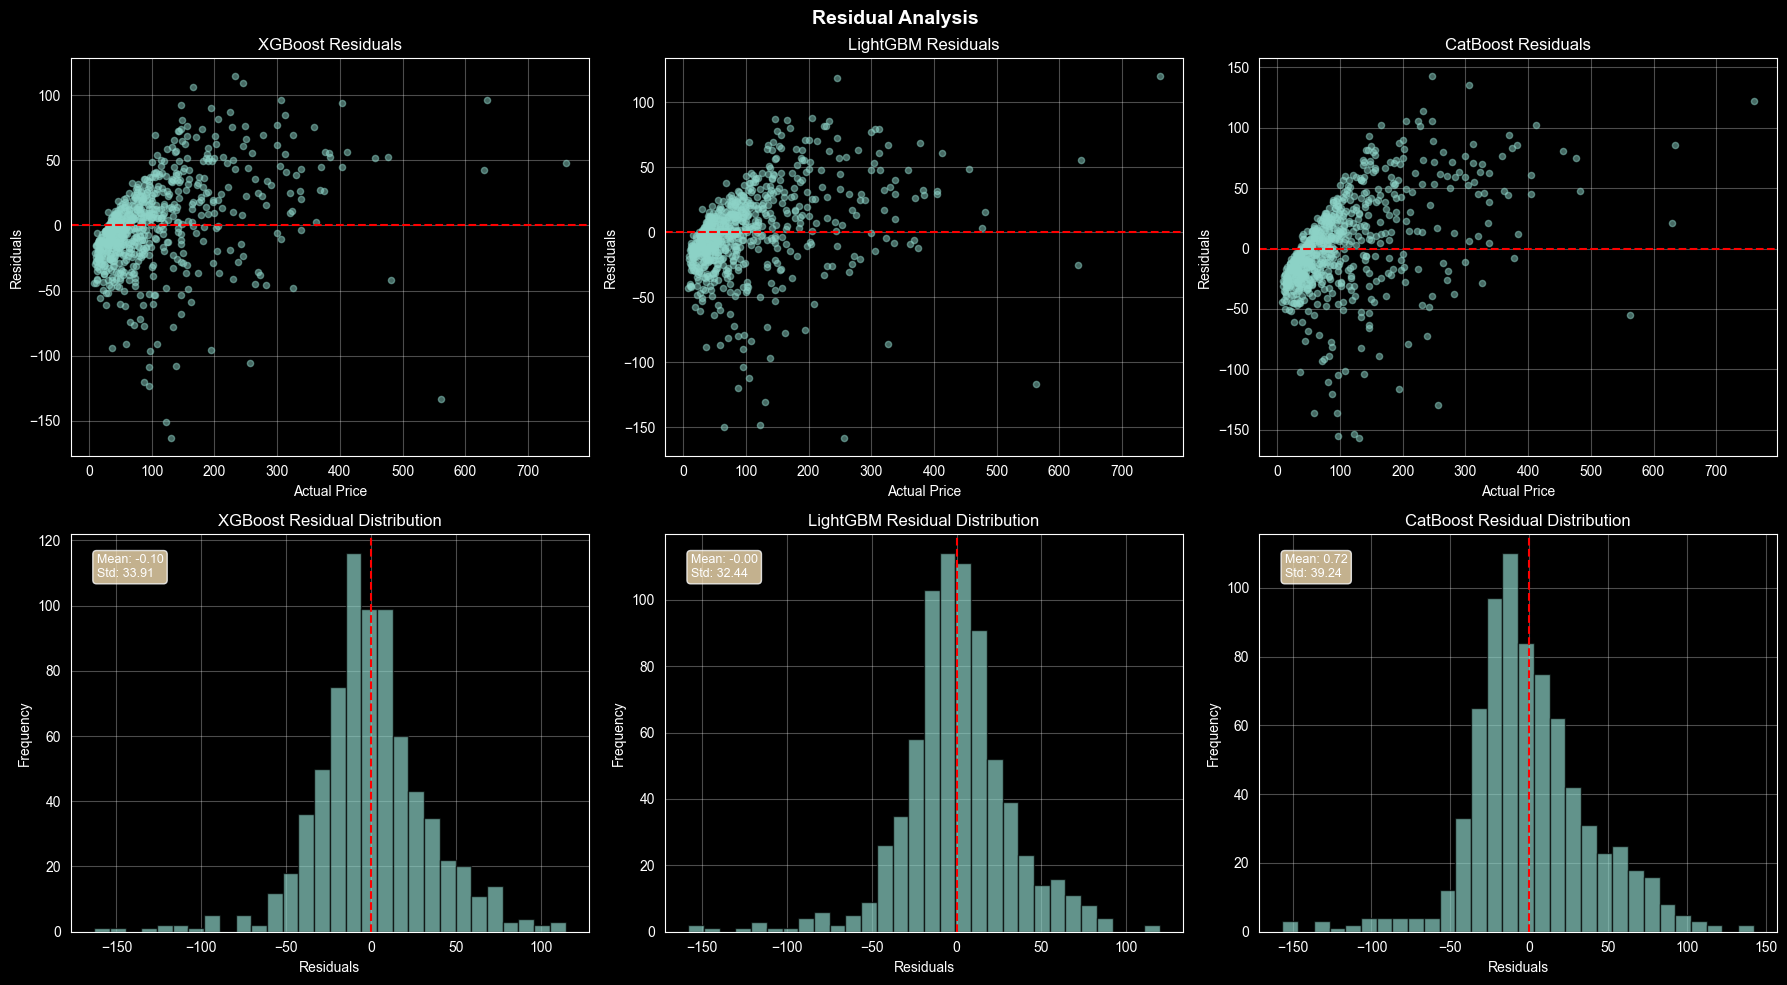

In [62]:
residuals = {
    'XGBoost': y_test - xgb_test_pred,
    'LightGBM': y_test - lgb_test_pred,
    'CatBoost': y_test - cb_test_pred
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (name, resid) in enumerate(residuals.items()):
    # Scatter
    ax = axes[0, i]
    ax.scatter(y_test, resid, alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'{name} Residuals')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Residuals')
    ax.grid(True, alpha=0.3)

    # Histogram
    ax = axes[1, i]
    ax.hist(resid, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'{name} Residual Distribution')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

    mean_resid = np.mean(resid)
    std_resid = np.std(resid)
    ax.text(0.05, 0.95, f'Mean: {mean_resid:.2f}\nStd: {std_resid:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Residual Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

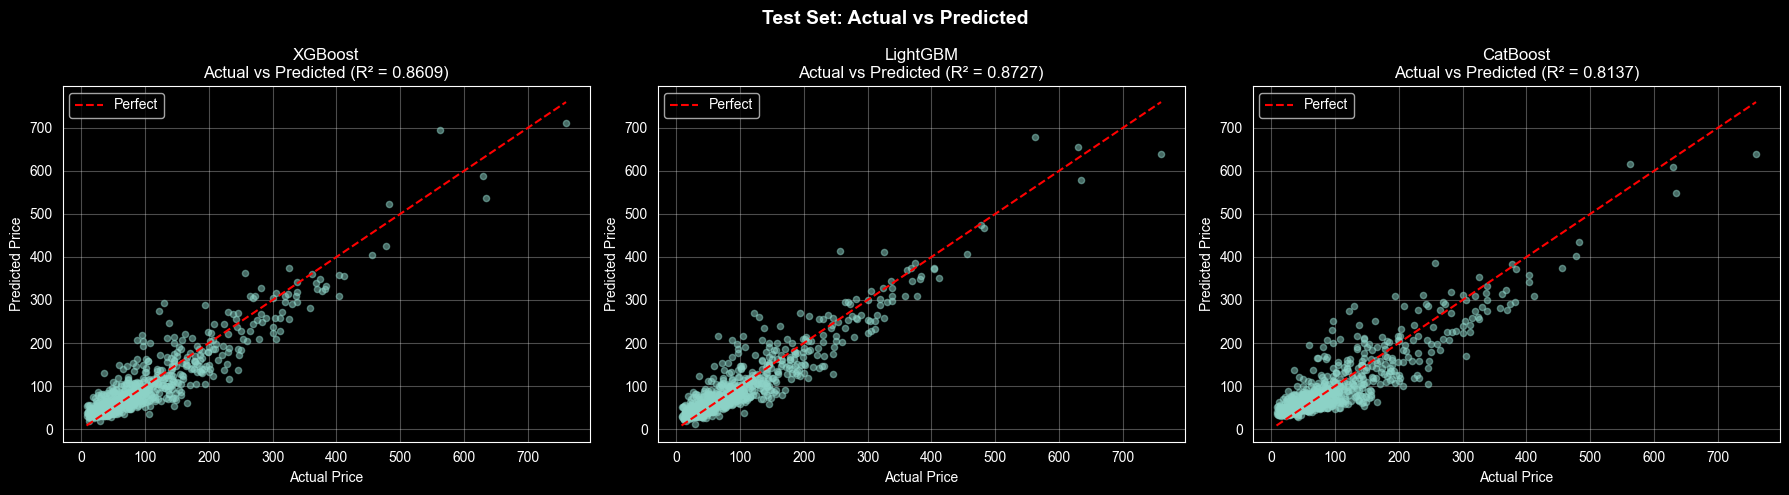

In [63]:
predictions = {
    'XGBoost': xgb_test_pred,
    'LightGBM': lgb_test_pred,
    'CatBoost': cb_test_pred
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, pred) in zip(axes, predictions.items()):
    ax.scatter(y_test, pred, alpha=0.5, s=20)
    min_val = min(y_test.min(), pred.min())
    max_val = max(y_test.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
    r2 = r2_score(y_test, pred)
    ax.set_title(f'{name}\nActual vs Predicted (R² = {r2:.4f})')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Test Set: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

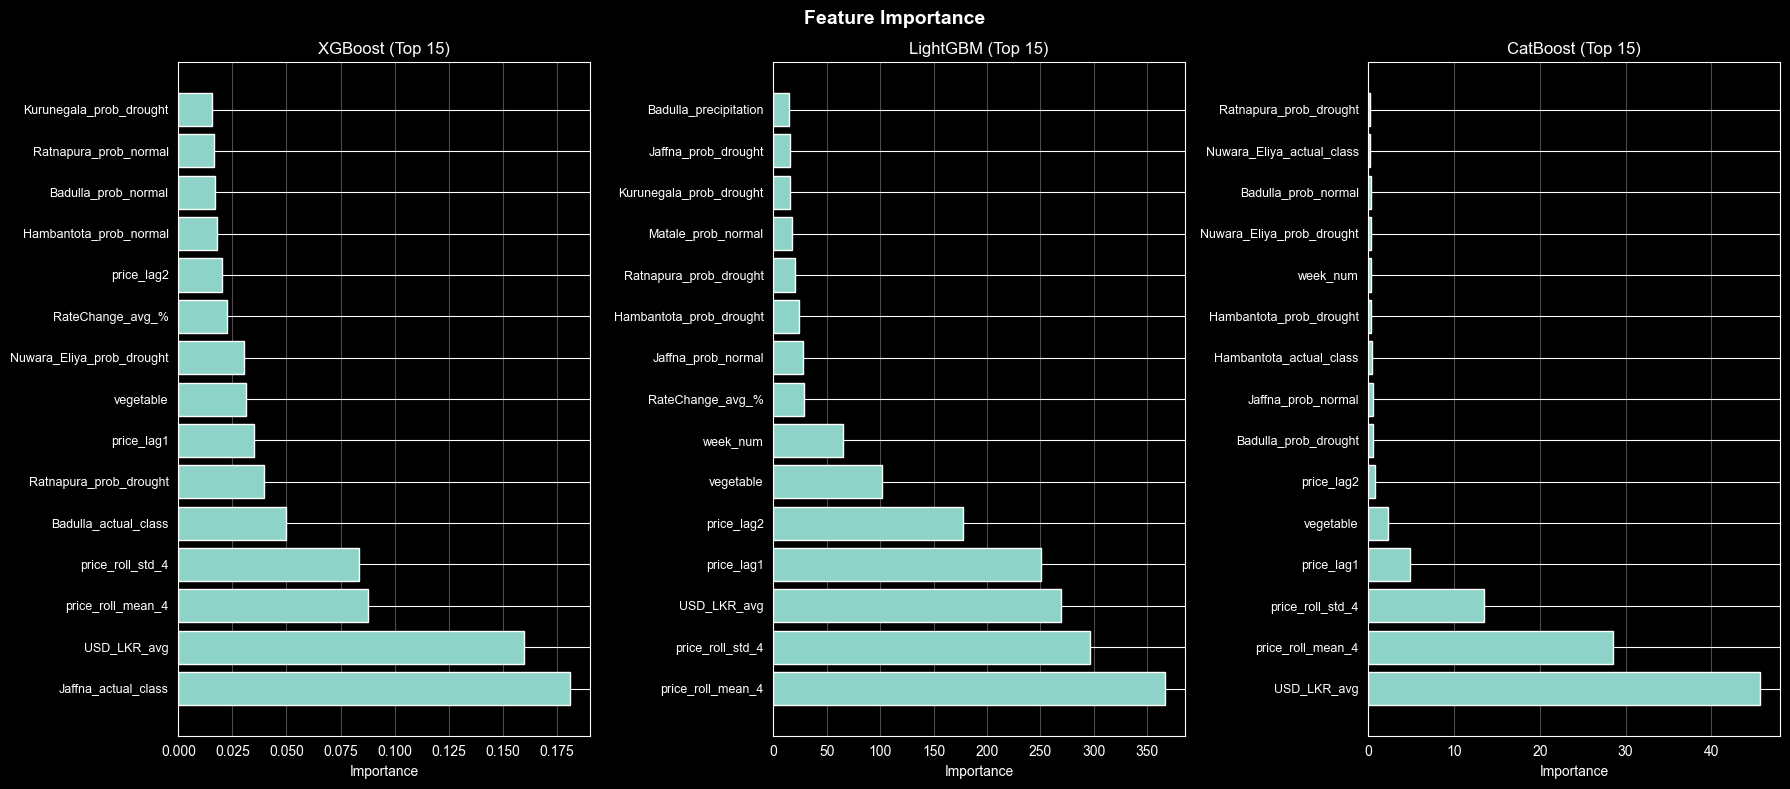

In [64]:
def plot_feature_importance(model, model_name, feature_names, ax):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-15:]
        top_features = [feature_names[i] for i in indices]
        top_importances = importances[indices]
        y_pos = np.arange(len(top_features))
        ax.barh(y_pos, top_importances, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features, fontsize=9)
        ax.invert_yaxis()
        ax.set_title(f'{model_name} (Top 15)')
        ax.set_xlabel('Importance')
        ax.grid(True, alpha=0.3, axis='x')
    else:
        ax.text(0.5, 0.5, 'No feature_importances_', ha='center')

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
plot_feature_importance(xgb_model, 'XGBoost', feature_cols, axes[0])
plot_feature_importance(lgb_model, 'LightGBM', feature_cols, axes[1])
plot_feature_importance(cb_model, 'CatBoost', feature_cols, axes[2])
plt.suptitle('Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

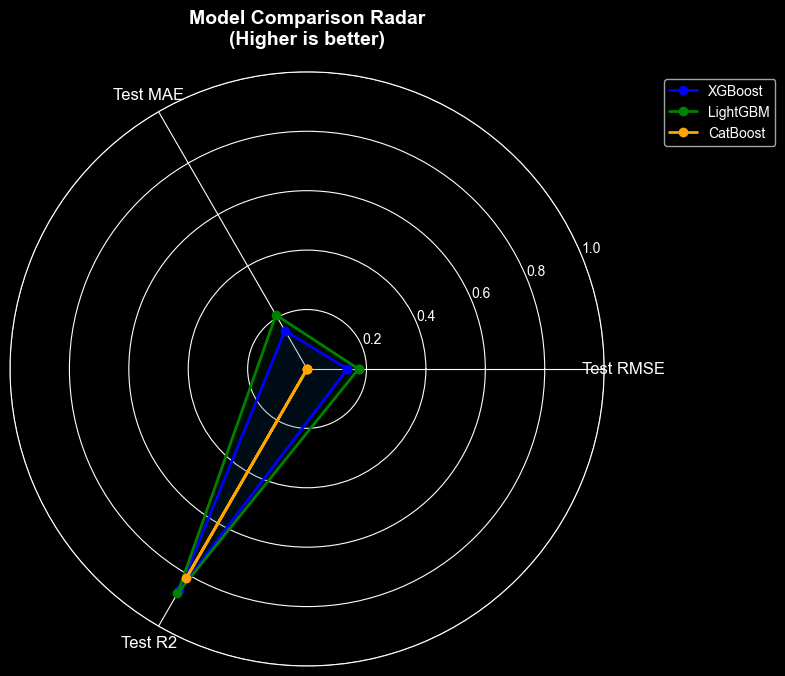

In [65]:
from math import pi

# Prepare metrics for radar (normalize)
metrics_for_radar = ['Test RMSE', 'Test MAE', 'Test R2']
xgb_vals = [xgb_metrics['Test RMSE'], xgb_metrics['Test MAE'], xgb_metrics['Test R2']]
lgb_vals = [lgb_metrics['Test RMSE'], lgb_metrics['Test MAE'], lgb_metrics['Test R2']]
cb_vals = [cb_metrics['Test RMSE'], cb_metrics['Test MAE'], cb_metrics['Test R2']]

# Normalize (1 is best)
max_rmse = max(xgb_vals[0], lgb_vals[0], cb_vals[0])
max_mae = max(xgb_vals[1], lgb_vals[1], cb_vals[1])
xgb_norm = [1 - xgb_vals[0]/max_rmse, 1 - xgb_vals[1]/max_mae, xgb_vals[2]]
lgb_norm = [1 - lgb_vals[0]/max_rmse, 1 - lgb_vals[1]/max_mae, lgb_vals[2]]
cb_norm = [1 - cb_vals[0]/max_rmse, 1 - cb_vals[1]/max_mae, cb_vals[2]]

N = len(metrics_for_radar)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

xgb_norm += xgb_norm[:1]
lgb_norm += lgb_norm[:1]
cb_norm += cb_norm[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, xgb_norm, 'o-', linewidth=2, label='XGBoost', color='blue')
ax.fill(angles, xgb_norm, alpha=0.1, color='blue')
ax.plot(angles, lgb_norm, 'o-', linewidth=2, label='LightGBM', color='green')
ax.fill(angles, lgb_norm, alpha=0.1, color='green')
ax.plot(angles, cb_norm, 'o-', linewidth=2, label='CatBoost', color='orange')
ax.fill(angles, cb_norm, alpha=0.1, color='orange')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Model Comparison Radar\n(Higher is better)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

In [66]:
def assess_overfitting(train_rmse, val_rmse, test_rmse):
    val_gap = val_rmse - train_rmse
    test_gap = test_rmse - train_rmse
    val_gap_pct = (val_gap / train_rmse) * 100
    test_gap_pct = (test_gap / train_rmse) * 100
    avg_gap_pct = (val_gap_pct + test_gap_pct) / 2
    if avg_gap_pct < 5:
        return "LOW", "✅ Generalizes well"
    elif avg_gap_pct < 15:
        return "MODERATE", "⚠️ Some overfitting"
    else:
        return "HIGH", "❌ Significant overfitting"

def accuracy_rating(r2):
    if r2 >= 0.9:
        return "EXCELLENT", "🌟 Very high"
    elif r2 >= 0.8:
        return "GOOD", "👍 Good"
    elif r2 >= 0.6:
        return "FAIR", "⚡ Moderate"
    elif r2 >= 0.4:
        return "POOR", "⚠️ Low"
    else:
        return "VERY POOR", "❌ Poor"

model_details = []
for model_name, model in models.items():
    if 'XGBoost' in model_name:
        train_rmse = xgb_metrics['Train RMSE']
        val_rmse = xgb_metrics['Validation RMSE']
        test_rmse = xgb_metrics['Test RMSE']
        test_r2 = xgb_metrics['Test R2']
        test_mae = xgb_metrics['Test MAE']
    elif 'LightGBM' in model_name:
        train_rmse = lgb_metrics['Train RMSE']
        val_rmse = lgb_metrics['Validation RMSE']
        test_rmse = lgb_metrics['Test RMSE']
        test_r2 = lgb_metrics['Test R2']
        test_mae = lgb_metrics['Test MAE']
    else:
        train_rmse = cb_metrics['Train RMSE']
        val_rmse = cb_metrics['Validation RMSE']
        test_rmse = cb_metrics['Test RMSE']
        test_r2 = cb_metrics['Test R2']
        test_mae = cb_metrics['Test MAE']

    overfit_level, overfit_desc = assess_overfitting(train_rmse, val_rmse, test_rmse)
    acc_rating, acc_desc = accuracy_rating(test_r2)

    model_details.append({
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Test R²': test_r2,
        'Overfitting Level': overfit_level,
        'Overfitting Desc': overfit_desc,
        'Accuracy Rating': acc_rating,
        'Accuracy Desc': acc_desc
    })

summary_df = pd.DataFrame(model_details)

print("="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Composite score for best model
summary_df['RMSE_norm'] = 1 - (summary_df['Test RMSE'] / summary_df['Test RMSE'].max())
summary_df['R2_norm'] = summary_df['Test R²'] / summary_df['Test R²'].max()
overfit_map = {'LOW': 1.0, 'MODERATE': 0.6, 'HIGH': 0.2}
summary_df['Overfit_score'] = summary_df['Overfitting Level'].map(overfit_map)
summary_df['Composite'] = 0.4*summary_df['R2_norm'] + 0.3*summary_df['RMSE_norm'] + 0.3*summary_df['Overfit_score']

best_idx = summary_df['Composite'].idxmax()
best_model = summary_df.loc[best_idx]

print(f"\n🏆 BEST MODEL (composite): {best_model['Model']}")
print(f"   Test RMSE: {best_model['Test RMSE']:.4f}, Test R²: {best_model['Test R²']:.4f}")
print(f"   Overfitting: {best_model['Overfitting Level']}, Accuracy: {best_model['Accuracy Rating']}")

📊 FINAL MODEL SUMMARY
                 Model  Train RMSE  Val RMSE  Test RMSE  Test MAE  Test R² Overfitting Level          Overfitting Desc Accuracy Rating Accuracy Desc
 XGBoost (Regularized)   31.405283 40.231744  33.907848 24.693104 0.860941              HIGH ❌ Significant overfitting            GOOD        👍 Good
LightGBM (Regularized)   33.500550 39.872619  32.440591 22.918325 0.872715          MODERATE       ⚠️ Some overfitting            GOOD        👍 Good
CatBoost (Regularized)   44.167480 48.608610  39.243624 28.999689 0.813733               LOW        ✅ Generalizes well            GOOD        👍 Good

🏆 BEST MODEL (composite): CatBoost (Regularized)
   Test RMSE: 39.2436, Test R²: 0.8137
   Overfitting: LOW, Accuracy: GOOD


In [67]:
models_dir = "../models/baseline_models_v2"
os.makedirs(models_dir, exist_ok=True)

for model_name, model in models.items():
    safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
    filename = f"{safe_name}.joblib"
    joblib.dump(model, os.path.join(models_dir, filename))
    print(f"✅ Saved: {filename}")

# Save metadata
metadata = summary_df[['Model', 'Test RMSE', 'Test MAE', 'Test R²', 'Overfitting Level', 'Accuracy Rating']].copy()
metadata['Best_Model'] = best_model['Model']
metadata['Generated'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
metadata.to_csv(os.path.join(models_dir, 'model_metadata.csv'), index=False)
print(f"✅ Saved model metadata")
print(f"\n📁 All models saved to: {os.path.abspath(models_dir)}")

✅ Saved: xgboost_regularized.joblib
✅ Saved: lightgbm_regularized.joblib
✅ Saved: catboost_regularized.joblib
✅ Saved model metadata

📁 All models saved to: C:\Users\Arosha IIT\OneDrive - Robert Gordon University\Desktop\DSGP\DSGP_Group_38\WholeSale-Price-Model\models\baseline_models_v2
